# Task 1: Unsupervised Domain Adaptation (UDA)

In [1]:
# Install required libraries
#!pip install torchvision matplotlib

import os, sys
import torch
import datetime
import numpy as np
import torchvision
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision import datasets, transforms
from matplotlib.pyplot import imshow, imsave
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder, MNIST, USPS


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Install necessary libraries
!pip install -q kaggle torchvision matplotlib

# Step 1: Upload your Kaggle API key
# from google.colab import files
# files.upload()  # Upload the `kaggle.json` file here.

# Step 2: Configure Kaggle API
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Step 3: Download the Office-31 dataset from Kaggle
!kaggle datasets download -d eduardolawsondasilva/office-31

Dataset URL: https://www.kaggle.com/datasets/eduardolawsondasilva/office-31
License(s): apache-2.0
 86%|████████████████████████████████▌     | 65.0M/75.8M [00:00<00:00, 89.4MB/s]
100%|██████████████████████████████████████| 75.8M/75.8M [00:00<00:00, 88.8MB/s]


In [ ]:
!unzip -q office-31.zip -d /kaggle/Office31
# Directory structure
data_dir = "/kaggle/Office31"
domains = ["amazon", "dslr", "webcam"]

Amazon dataset size: 2817


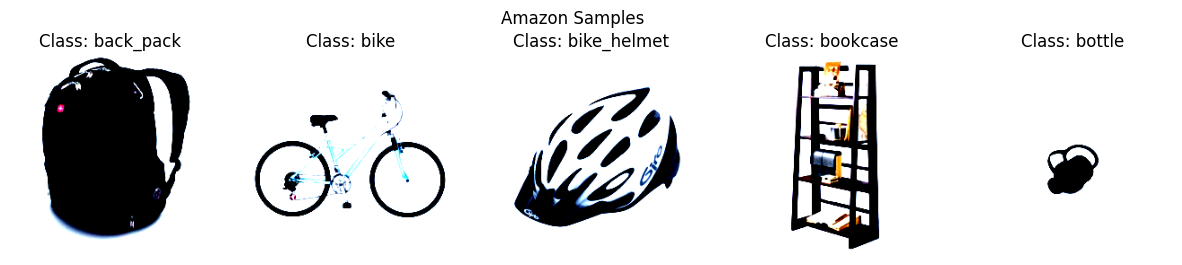

DSLR dataset size: 498


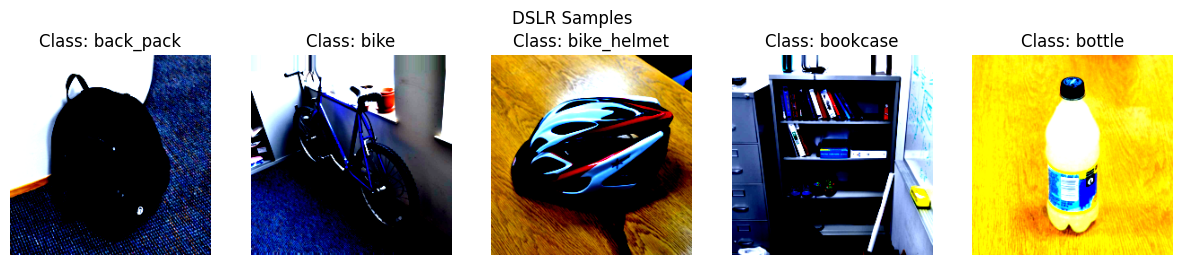

Webcam dataset size: 795


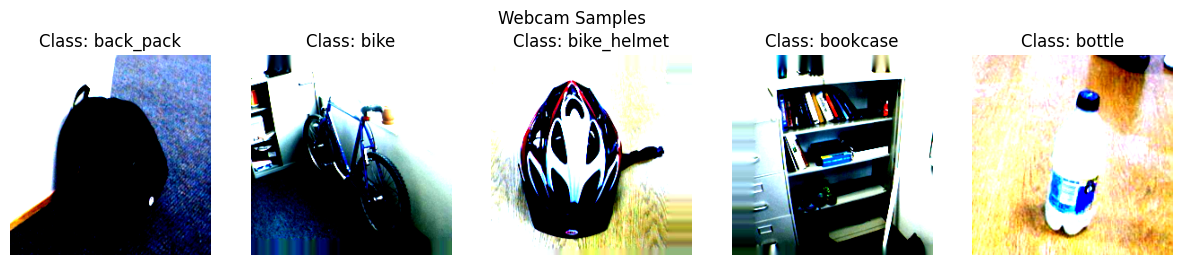

Source loader size: 177
Total classes: 31


In [ ]:
# Transformations for the dataset
office_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 5: Load Office-31 dataset
def load_office31(domain_name):
    # Updated path to point directly to the folder containing class directories
    domain_path = os.path.join(data_dir, domain_name, "images")
    dataset = ImageFolder(root=domain_path, transform=office_transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
    return dataset, loader


# Example: Load Amazon domain
amazon_dataset, amazon_loader = load_office31("amazon")
print(f"Amazon dataset size: {len(amazon_dataset)}")

# Visualize some samples
def visualize_samples(dataset, title="Sample Images"):
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse the mapping

    # Collect one sample for each class
    samples = []
    for class_idx in range(len(class_to_idx)):
        for img, label in dataset:
            if label == class_idx:
                samples.append((img, label))
                break
        if len(samples) >= 5:  # Stop after collecting 5 samples
            break

    # Display images
    fig, ax = plt.subplots(1, len(samples), figsize=(15, 3))
    for i, (img, label) in enumerate(samples):
        ax[i].imshow(img.permute(1, 2, 0).numpy())
        ax[i].set_title(f"Class: {idx_to_class[label]}")
        ax[i].axis("off")
    plt.suptitle(title)
    plt.show()


visualize_samples(amazon_dataset, title="Amazon Samples")


dslr_dataset, dslr_loader = load_office31("dslr")
print(f"DSLR dataset size: {len(dslr_dataset)}")
visualize_samples(dslr_dataset, title="DSLR Samples")
webcam_dataset, webcam_loader = load_office31("webcam")
print(f"Webcam dataset size: {len(webcam_dataset)}")
visualize_samples(webcam_dataset, title="Webcam Samples")

# Example transfer task: Amazon → DSLR
source_loader = amazon_loader
target_loader = dslr_loader

print(f"Source loader size: {len(source_loader)}")
#print total classes
print(f"Total classes: {len(amazon_dataset.classes)}")

In [ ]:
office_31_classes = amazon_dataset.classes
print(office_31_classes)

['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, USPS, SVHN
import matplotlib.pyplot as plt

digits_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel (RGB)
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load MNIST dataset
def load_mnist(data_dir):
    mnist_dataset = MNIST(root=data_dir, train=True, download=True, transform=digits_transform)
    mnist_loader = DataLoader(mnist_dataset, batch_size=32, shuffle=True, num_workers=2)
    # Limit to max 5000 images
    mnist_dataset.data = mnist_dataset.data[:5000]
    mnist_dataset.targets = mnist_dataset.targets[:5000]
    return mnist_dataset, mnist_loader

# Load USPS dataset
def load_usps(data_dir):
    usps_dataset = USPS(root=data_dir, train=True, download=True, transform=digits_transform)
    usps_loader = DataLoader(usps_dataset, batch_size=32, shuffle=True, num_workers=2)
    # Limit to max 5000 images
    usps_dataset.data = usps_dataset.data[:5000]
    usps_dataset.targets = usps_dataset.targets[:5000]
    return usps_dataset, usps_loader

# Example: Load MNIST and USPS
mnist_dataset, mnist_loader = load_mnist('./data')
usps_dataset, usps_loader = load_usps('./data')

print(f"MNIST dataset size: {len(mnist_dataset)}")
print(f"USPS dataset size: {len(usps_dataset)}")

# Visualize some samples from MNIST
# def visualize_samples(dataset, title="Sample Images"):
#     fig, ax = plt.subplots(1, 5, figsize=(15, 3))
#     for i in range(5):
#         img, label = dataset[i]
#         ax[i].imshow(img.squeeze(), cmap="gray")
#         ax[i].set_title(f"Label: {label}")
#         ax[i].axis("off")
#     plt.suptitle(title)
#     plt.show()

# visualize_samples(mnist_dataset, title="MNIST Samples")
# visualize_samples(usps_dataset, title="USPS Samples")

# Load SVHN dataset
def load_svhn(data_dir):
    svhn_dataset = SVHN(root=data_dir, split='train', transform=digits_transform, download=True)
    svhn_loader = DataLoader(svhn_dataset, batch_size=32, shuffle=True, num_workers=2)
    # Limit to max 5000 images
    svhn_dataset.data = svhn_dataset.data[:5000]
    svhn_dataset.labels = svhn_dataset.labels[:5000]
    return svhn_dataset, svhn_loader

# Example: Load SVHN
svhn_dataset, svhn_loader = load_svhn('./data')

print(f"SVHN dataset size: {len(svhn_dataset)}")

# Visualize some samples from SVHN
# visualize_samples(svhn_dataset, title="SVHN Samples")

# Placeholder for UDA Implementation
# Define source and target data loaders, and implement your UDA strategy here.


MNIST dataset size: 5000
USPS dataset size: 5000
Using downloaded and verified file: ./data/train_32x32.mat
SVHN dataset size: 5000


In [3]:
print(f"SVHN dataset size: {len(svhn_dataset)}")
print(f"MNIST dataset size: {len(mnist_dataset)}")
print(f"USPS dataset size: {len(usps_dataset)}")

SVHN dataset size: 5000
MNIST dataset size: 5000
USPS dataset size: 5000


In [4]:
# 5. Training placeholder
def train_model(model, source_loader, target_loader, device, epochs=10, lr=0.001):
    """Trains the model on the source domain."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    model = model.to(device)
    for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
        model.train()
        total_loss = 0.0
        for inputs, labels in source_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"  Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(source_loader):.4f}")

# 6. Evaluation placeholder
def evaluate_model(model, data_loader, device):
    """Evaluates the model on the target domain."""
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


# Resnet 50

In [ ]:
epochs = 5
lr = 0.001
num_classes = 31
domains = ["amazon", "dslr", "webcam"]
accuracy_results = {}
for source in domains:
    model = None
    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    print(f"============== Training {source}... =============")
    source_dataset, source_loader = load_office31(source)
    train_model(model, source_loader, None, device, epochs, lr)
    accuracy = evaluate_model(model, source_loader, device)
    print(f"Accuracy with {source}: {accuracy * 100:.2f}%")
    accuracy_results[(source, source)] = accuracy
    print(f"NOW Evaluating {source} on other domains...")
    for target in domains:
        if source != target:
            target_dataset, target_loader = load_office31(target)
            accuracy = evaluate_model(model, target_loader, device)
            print(f"Accuracy with {source} to {target}: {accuracy * 100:.2f}%")
            accuracy_results[(source, target)] = accuracy

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============== Training amazon... =============


Training:  20%|██        | 1/5 [00:27<01:50, 27.58s/epoch]

  Epoch [1/5], Loss: 2.3096


Training:  40%|████      | 2/5 [00:55<01:23, 27.99s/epoch]

  Epoch [2/5], Loss: 1.6074


Training:  60%|██████    | 3/5 [01:24<00:56, 28.24s/epoch]

  Epoch [3/5], Loss: 1.2801


Training:  80%|████████  | 4/5 [01:53<00:28, 28.68s/epoch]

  Epoch [4/5], Loss: 1.0281


Training: 100%|██████████| 5/5 [02:23<00:00, 28.67s/epoch]

  Epoch [5/5], Loss: 0.9172


Accuracy with amazon: 71.25%
NOW Evaluating amazon on other domains...
Accuracy with amazon to dslr: 20.88%
Accuracy with amazon to webcam: 23.14%
============== Training dslr... =============


Training:  20%|██        | 1/5 [00:07<00:29,  7.36s/epoch]

  Epoch [1/5], Loss: 2.1308


Training:  40%|████      | 2/5 [00:13<00:20,  6.92s/epoch]

  Epoch [2/5], Loss: 0.9009


Training:  60%|██████    | 3/5 [00:21<00:14,  7.08s/epoch]

  Epoch [3/5], Loss: 0.5868


Training:  80%|████████  | 4/5 [00:27<00:06,  6.92s/epoch]

  Epoch [4/5], Loss: 0.3701


Training: 100%|██████████| 5/5 [00:35<00:00,  7.11s/epoch]

  Epoch [5/5], Loss: 0.2793


Accuracy with dslr: 72.49%
NOW Evaluating dslr on other domains...
Accuracy with dslr to amazon: 5.08%
Accuracy with dslr to webcam: 33.71%
============== Training webcam... =============


Training:  20%|██        | 1/5 [00:08<00:34,  8.75s/epoch]

  Epoch [1/5], Loss: 1.7719


Training:  40%|████      | 2/5 [00:17<00:26,  8.75s/epoch]

  Epoch [2/5], Loss: 0.7236


Training:  60%|██████    | 3/5 [00:26<00:17,  8.76s/epoch]

  Epoch [3/5], Loss: 0.4911


Training:  80%|████████  | 4/5 [00:35<00:08,  8.76s/epoch]

  Epoch [4/5], Loss: 0.2806


Training: 100%|██████████| 5/5 [00:43<00:00,  8.78s/epoch]

  Epoch [5/5], Loss: 0.1690


Accuracy with webcam: 94.34%
NOW Evaluating webcam on other domains...
Accuracy with webcam to amazon: 14.27%
Accuracy with webcam to dslr: 64.46%


In [ ]:
# Print the final results
for x in accuracy_results.items():
    print(x)
    #print(f"Source: {source}, Target: {target}, Accuracy: {acc * 100:.2f}%")

(('amazon', 'amazon'), 0.7124600638977636)
(('amazon', 'dslr'), 0.20883534136546184)
(('amazon', 'webcam'), 0.23144654088050315)
(('dslr', 'dslr'), 0.7248995983935743)
(('dslr', 'amazon'), 0.050763223287184946)
(('dslr', 'webcam'), 0.3371069182389937)
(('webcam', 'webcam'), 0.9433962264150944)
(('webcam', 'amazon'), 0.14270500532481364)
(('webcam', 'dslr'), 0.6445783132530121)


In [ ]:
# Function to load data based on domain
def load_digit_dataset(domain):
    if domain == "mnist":
        return load_mnist('./data')
    elif domain == "usps":
        return load_usps('./data')
    elif domain == "svhn":
        return load_svhn('./data')

epochs = 5
lr = 0.001
num_classes = 10  # Number of classes for MNIST, USPS, and SVHN
domains = ["mnist", "usps", "svhn"]
accuracy_results = {}
for source in domains:
    # Initialize the model
    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    print(f"============== Training on {source}... =============")
    source_dataset, source_loader = load_digit_dataset(source)
    train_model(model, source_loader, None, device, epochs, lr)
    accuracy = evaluate_model(model, source_loader, device)
    print(f"Accuracy with {source}: {accuracy * 100:.2f}%")
    accuracy_results[(source, source)] = accuracy

    print(f"NOW Evaluating {source} on other domains...")
    for target in domains:
        if source != target:
            target_dataset, target_loader = load_digit_dataset(target)
            accuracy = evaluate_model(model, target_loader, device)
            print(f"Accuracy with {source} to {target}: {accuracy * 100:.2f}%")
            accuracy_results[(source, target)] = accuracy

for x in accuracy_results.items():
    print(x)

============== Training on mnist... =============


Training:  20%|██        | 1/5 [00:48<03:14, 48.53s/epoch]

  Epoch [1/5], Loss: 0.3200


Training:  40%|████      | 2/5 [01:38<02:27, 49.14s/epoch]

  Epoch [2/5], Loss: 0.1297


Training:  60%|██████    | 3/5 [02:29<01:40, 50.21s/epoch]

  Epoch [3/5], Loss: 0.1149


Training:  80%|████████  | 4/5 [03:20<00:50, 50.51s/epoch]

  Epoch [4/5], Loss: 0.1304


Training: 100%|██████████| 5/5 [04:11<00:00, 50.33s/epoch]

  Epoch [5/5], Loss: 0.0693


Accuracy with mnist: 96.10%
NOW Evaluating mnist on other domains...
Accuracy with mnist to usps: 70.48%
Using downloaded and verified file: ./data/train_32x32.mat
Accuracy with mnist to svhn: 18.74%
============== Training on usps... =============


Training:  20%|██        | 1/5 [00:51<03:26, 51.59s/epoch]

  Epoch [1/5], Loss: 0.2236


Training:  40%|████      | 2/5 [01:42<02:34, 51.42s/epoch]

  Epoch [2/5], Loss: 0.1272


Training:  60%|██████    | 3/5 [02:34<01:43, 51.51s/epoch]

  Epoch [3/5], Loss: 0.0997


Training:  80%|████████  | 4/5 [03:25<00:51, 51.50s/epoch]

  Epoch [4/5], Loss: 0.0538


Training: 100%|██████████| 5/5 [04:17<00:00, 51.45s/epoch]

  Epoch [5/5], Loss: 0.0768


Accuracy with usps: 97.64%
NOW Evaluating usps on other domains...
Accuracy with usps to mnist: 68.76%
Using downloaded and verified file: ./data/train_32x32.mat
Accuracy with usps to svhn: 11.26%
============== Training on svhn... =============
Using downloaded and verified file: ./data/train_32x32.mat


Training:  20%|██        | 1/5 [00:51<03:27, 51.76s/epoch]

  Epoch [1/5], Loss: 1.6796


Training:  40%|████      | 2/5 [01:43<02:34, 51.55s/epoch]

  Epoch [2/5], Loss: 0.7378


Training:  60%|██████    | 3/5 [02:34<01:43, 51.52s/epoch]

  Epoch [3/5], Loss: 0.5036


Training:  80%|████████  | 4/5 [03:25<00:51, 51.37s/epoch]

  Epoch [4/5], Loss: 0.4551


Training: 100%|██████████| 5/5 [04:17<00:00, 51.42s/epoch]

  Epoch [5/5], Loss: 0.3352


Accuracy with svhn: 87.04%
NOW Evaluating svhn on other domains...
Accuracy with svhn to mnist: 62.78%
Accuracy with svhn to usps: 63.00%
(('mnist', 'mnist'), 0.961)
(('mnist', 'usps'), 0.7048)
(('mnist', 'svhn'), 0.1874)
(('usps', 'usps'), 0.9764)
(('usps', 'mnist'), 0.6876)
(('usps', 'svhn'), 0.1126)
(('svhn', 'svhn'), 0.8704)
(('svhn', 'mnist'), 0.6278)
(('svhn', 'usps'), 0.63)


# Visulaizing the Feature Distribution

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============== Training on mnist... =============
Visualizing feature distributions for mnist to other domains...


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


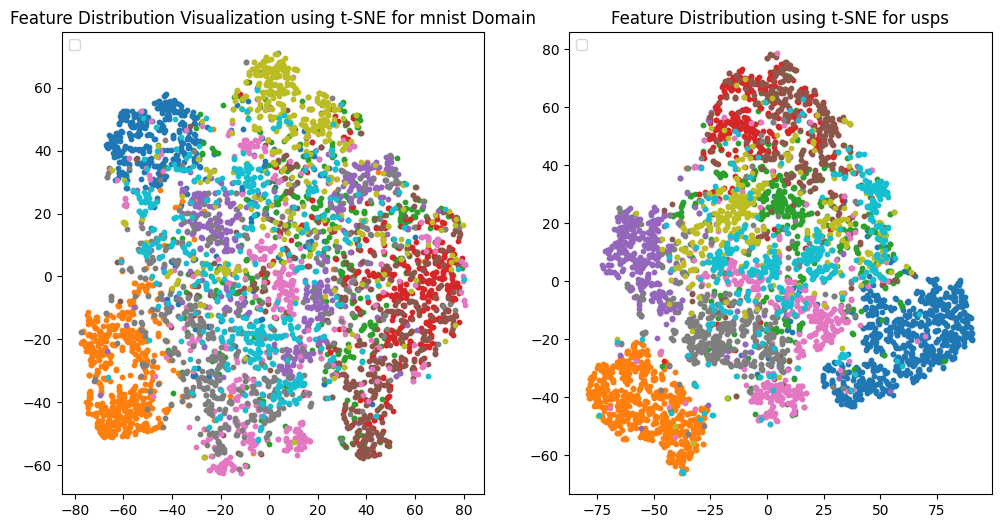

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============== Training on usps... =============
Visualizing feature distributions for usps to other domains...


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


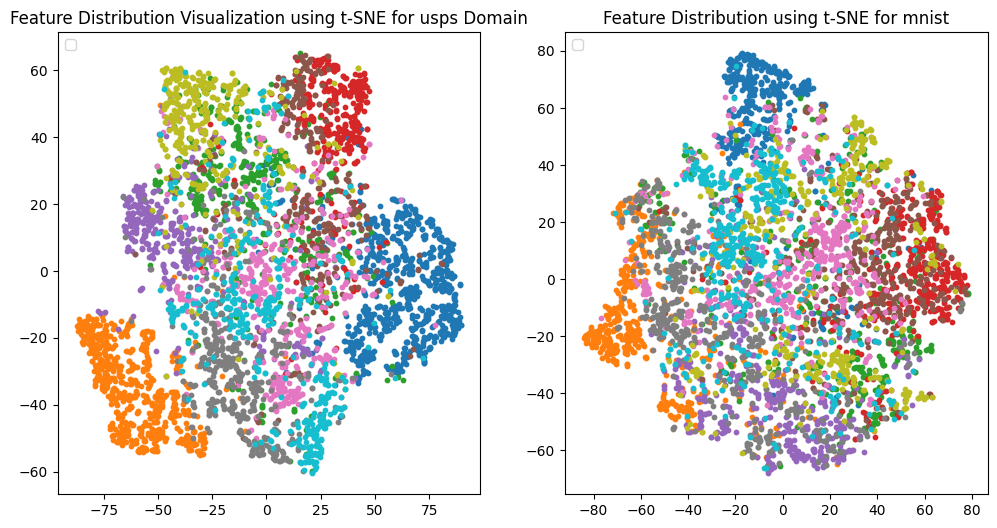

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============== Training on svhn... =============
Using downloaded and verified file: ./data/train_32x32.mat
Visualizing feature distributions for svhn to other domains...


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


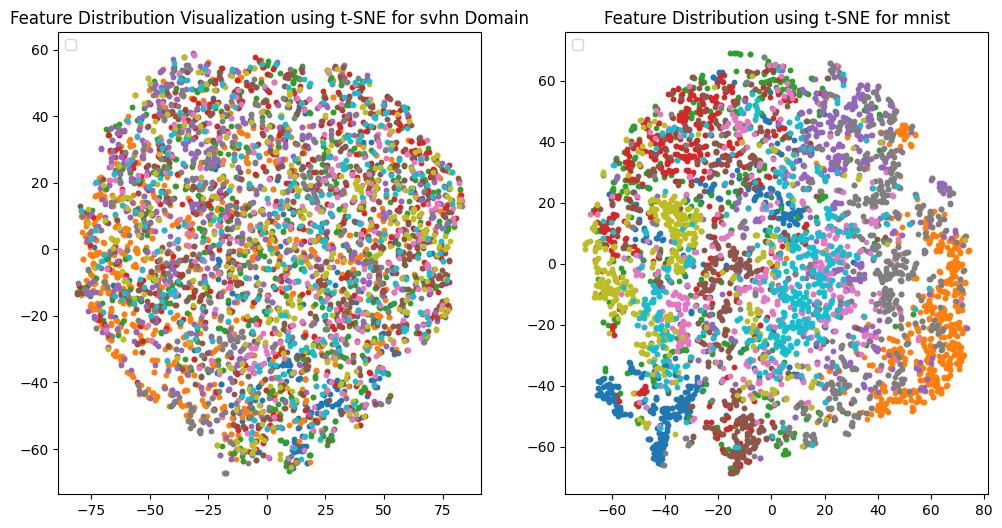

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to load data based on domain
def load_digit_dataset(domain):
    if domain == "mnist":
        return load_mnist('./data')
    elif domain == "usps":
        return load_usps('./data')
    elif domain == "svhn":
        return load_svhn('./data')

# Visualization function
def visualize_feature_distributions(model, source_loader, target_loader, device, source, target_D):
    model.eval()
    source_features, target_features = [], []
    source_labels, target_labels = [], []
    domain_labels_source, domain_labels_target = [], []  # To store domain information for color-coding
    domain_map = {"mnist": 0, "usps": 1, "svhn": 2}  # Mapping domain names to numbers

    # Collect features and labels for the source domain
    with torch.no_grad():
        for inputs, target in source_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            source_features.append(outputs.cpu().numpy())
            source_labels.append(target.numpy())
            domain_labels_source.extend([domain_map[source]] * len(target))

    # Collect features and labels for the target domain
    with torch.no_grad():
        for inputs, target in target_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            target_features.append(outputs.cpu().numpy())
            target_labels.append(target.numpy())
            domain_labels_target.extend([domain_map[target_D]] * len(target))

    # Concatenate features and labels
    source_features = np.concatenate(source_features, axis=0)
    source_labels = np.concatenate(source_labels, axis=0)
    target_features = np.concatenate(target_features, axis=0)
    target_labels = np.concatenate(target_labels, axis=0)

    # Apply t-SNE for visualization
    # tsne = TSNE(n_components=2, random_state=42)
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)

    reduced_source_features = tsne.fit_transform(source_features)
    reduced_target_features = tsne.fit_transform(target_features)

    # Plot source features by class
    plt.figure(figsize=(12, 6))

    # Create a scatter plot for each class in the source domain
    for class_id in np.unique(source_labels):
        class_indices = np.where(source_labels == class_id)[0]
        plt.subplot(1, 2, 1)
        scatter_source = plt.scatter(reduced_source_features[class_indices, 0],
                                     reduced_source_features[class_indices, 1],
                                     label=f"Class {class_id}",
                                     s=10)
    plt.legend(handles=scatter_source.legend_elements()[0], loc='upper left')
    plt.title(f"Feature Distribution Visualization using t-SNE for {source}")

    # Plot target features by class
    for class_id in np.unique(target_labels):
        class_indices = np.where(target_labels == class_id)[0]
        plt.subplot(1, 2, 2)
        scatter_target = plt.scatter(reduced_target_features[class_indices, 0],
                                     reduced_target_features[class_indices, 1],
                                     label=f"Class {class_id}",
                                     s=10)
    plt.legend(handles=scatter_target.legend_elements()[0], loc='upper left')
    plt.title(f"Feature Distribution using t-SNE for {target_D}")

    plt.show()


# Main script
epochs = 5
lr = 0.001
num_classes = 10  # Number of classes for MNIST, USPS, and SVHN
domains = ["mnist", "usps", "svhn"]

for source in domains:
    # Initialize the model
    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    print(f"============== Training on {source}... =============")
    source_dataset, source_loader = load_digit_dataset(source)
    # train_model(model, source_loader, None, device, epochs, lr)
    # accuracy = evaluate_model(model, source_loader, device)
    # print(f"Accuracy with {source}: {accuracy * 100:.2f}%")
    # accuracy_results[(source, source)] = accuracy
    # # Visualize feature distributions
    print(f"Visualizing feature distributions for {source} to other domains...")
    for target in domains:
        if source != target:
            if (source, target) in [("mnist", "usps"), ("usps", "mnist"), ("svhn", "mnist")]:  # Only visualize specific pairs
                target_dataset, target_loader = load_digit_dataset(target)
                visualize_feature_distributions(model, source_loader, target_loader, device, source, target)


# DAN-Domain-Adaptation Network

In [17]:
# Define the MMD Loss
class MMDLoss(nn.Module):
    def __init__(self):
        super(MMDLoss, self).__init__()

    def forward(self, source_features, target_features):
        """Compute the Maximum Mean Discrepancy (MMD) loss."""
        source_mean = torch.mean(source_features, dim=0)
        target_mean = torch.mean(target_features, dim=0)
        return torch.sum((source_mean - target_mean) ** 2)

# Define the DAN model
class DAN(nn.Module):
    def __init__(self, num_classes):
        super(DAN, self).__init__()
        # Feature extractor (ResNet backbone without the classifier)
        self.feature_extractor = resnet50(pretrained=True)
        self.feature_extractor.fc = nn.Identity()  # Remove the final classification layer

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        predictions = self.classifier(features)
        return features, predictions

# Training function for DAN
def train_dan(model, source_loader, target_loader, device, epochs, lr):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    mmd_loss = MMDLoss()

    for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
        model.train()
        total_loss = 0.0

        # Loop through source and target data
        for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)

            optimizer.zero_grad()

            # Forward pass
            source_features, source_predictions = model(source_data)
            target_features, _ = model(target_data)

            # Compute losses
            classification_loss = criterion(source_predictions, source_labels)
            domain_loss = mmd_loss(source_features, target_features)
            loss = classification_loss + domain_loss

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(source_loader):.4f}")

# Evaluation function for DAN
def evaluate_dan(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, predictions = model(inputs)
            _, preds = torch.max(predictions, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [ ]:
# Hyperparameters
epochs = 5
lr = 0.001
num_classes = 31  # Office-31 has 31 classes

# Define the domains
domains = ["amazon", "dslr", "webcam"]
accuracy_results_DAN = {}

# Train and evaluate DAN for each domain transfer task
for source in domains:
    for target in domains:
        if source != target:

            dan_model = DAN(num_classes).to(device)
            dan_model = dan_model.to(device)

            print(f"========== Training DAN from {source} to {target}... =========")
            source_dataset, source_loader = load_office31(source)
            target_dataset, target_loader = load_office31(target)

            train_dan(dan_model, source_loader, target_loader, device, epochs, lr)
            accuracy_source = evaluate_dan(dan_model, source_loader, device)
            print(f"Accuracy with {source}: {accuracy_source * 100:.2f}%")
            accuracy = evaluate_dan(dan_model, target_loader, device)
            print(f"Accuracy with DAN {source} to {target}: {accuracy * 100:.2f}%")
            accuracy_results_DAN[(source, target)] = accuracy

# Print the final results
for (source, target), acc in accuracy_results_DAN.items():
    print(f"Source: {source}, Target: {target}, Accuracy: {acc * 100:.2f}%")

========== Training DAN from amazon to dslr... =========


Training:  20%|██        | 1/5 [00:12<00:48, 12.12s/epoch]

Epoch [1/5], Loss: 0.6870


Training:  40%|████      | 2/5 [00:24<00:36, 12.03s/epoch]

Epoch [2/5], Loss: 0.6017


Training:  60%|██████    | 3/5 [00:36<00:24, 12.34s/epoch]

Epoch [3/5], Loss: 0.5656


Training:  80%|████████  | 4/5 [00:49<00:12, 12.56s/epoch]

Epoch [4/5], Loss: 0.5240


Training: 100%|██████████| 5/5 [01:02<00:00, 12.51s/epoch]

Epoch [5/5], Loss: 0.5120


Accuracy with amazon: 16.51%
Accuracy with DAN amazon to dslr: 6.02%
========== Training DAN from amazon to webcam... =========


Training:  20%|██        | 1/5 [00:17<01:11, 17.94s/epoch]

Epoch [1/5], Loss: 1.0540


Training:  40%|████      | 2/5 [00:36<00:55, 18.35s/epoch]

Epoch [2/5], Loss: 0.8974


Training:  60%|██████    | 3/5 [00:55<00:36, 18.39s/epoch]

Epoch [3/5], Loss: 0.8293


Training:  80%|████████  | 4/5 [01:13<00:18, 18.36s/epoch]

Epoch [4/5], Loss: 0.7859


Training: 100%|██████████| 5/5 [01:31<00:00, 18.39s/epoch]

Epoch [5/5], Loss: 0.7661


Accuracy with amazon: 21.73%
Accuracy with DAN amazon to webcam: 9.81%
========== Training DAN from dslr to amazon... =========


Training:  20%|██        | 1/5 [00:12<00:49, 12.30s/epoch]

Epoch [1/5], Loss: 3.6183


Training:  40%|████      | 2/5 [00:24<00:36, 12.31s/epoch]

Epoch [2/5], Loss: 2.7566


Training:  60%|██████    | 3/5 [00:36<00:24, 12.28s/epoch]

Epoch [3/5], Loss: 2.1042


Training:  80%|████████  | 4/5 [00:49<00:12, 12.26s/epoch]

Epoch [4/5], Loss: 1.7763


Training: 100%|██████████| 5/5 [01:01<00:00, 12.27s/epoch]

Epoch [5/5], Loss: 1.3692


Accuracy with dslr: 68.27%
Accuracy with DAN dslr to amazon: 12.35%
========== Training DAN from dslr to webcam... =========


Training:  20%|██        | 1/5 [00:12<00:50, 12.52s/epoch]

Epoch [1/5], Loss: 3.9134


Training:  40%|████      | 2/5 [00:25<00:38, 12.69s/epoch]

Epoch [2/5], Loss: 3.1131


Training:  60%|██████    | 3/5 [00:38<00:25, 12.80s/epoch]

Epoch [3/5], Loss: 2.4892


Training:  80%|████████  | 4/5 [00:50<00:12, 12.65s/epoch]

Epoch [4/5], Loss: 1.9989


Training: 100%|██████████| 5/5 [01:03<00:00, 12.61s/epoch]

Epoch [5/5], Loss: 1.6786


Accuracy with dslr: 52.61%
Accuracy with DAN dslr to webcam: 43.02%
========== Training DAN from webcam to amazon... =========


Training:  20%|██        | 1/5 [00:18<01:14, 18.62s/epoch]

Epoch [1/5], Loss: 3.3199


Training:  40%|████      | 2/5 [00:36<00:55, 18.37s/epoch]

Epoch [2/5], Loss: 2.2474


Training:  60%|██████    | 3/5 [00:54<00:36, 18.27s/epoch]

Epoch [3/5], Loss: 1.6633


Training:  80%|████████  | 4/5 [01:13<00:18, 18.29s/epoch]

Epoch [4/5], Loss: 1.4763


Training: 100%|██████████| 5/5 [01:31<00:00, 18.22s/epoch]

Epoch [5/5], Loss: 1.2841


Accuracy with webcam: 67.67%
Accuracy with DAN webcam to amazon: 14.45%
========== Training DAN from webcam to dslr... =========


Training:  20%|██        | 1/5 [00:12<00:51, 12.83s/epoch]

Epoch [1/5], Loss: 2.1950


Training:  40%|████      | 2/5 [00:25<00:38, 12.71s/epoch]

Epoch [2/5], Loss: 1.5936


Training:  60%|██████    | 3/5 [00:38<00:25, 12.71s/epoch]

Epoch [3/5], Loss: 1.1954


Training:  80%|████████  | 4/5 [00:50<00:12, 12.63s/epoch]

Epoch [4/5], Loss: 1.0520


Training: 100%|██████████| 5/5 [01:03<00:00, 12.68s/epoch]

Epoch [5/5], Loss: 0.8222


Accuracy with webcam: 73.33%
Accuracy with DAN webcam to dslr: 43.57%
Source: amazon, Target: dslr, Accuracy: 6.02%
Source: amazon, Target: webcam, Accuracy: 9.81%
Source: dslr, Target: amazon, Accuracy: 12.35%
Source: dslr, Target: webcam, Accuracy: 43.02%
Source: webcam, Target: amazon, Accuracy: 14.45%
Source: webcam, Target: dslr, Accuracy: 43.57%


MNIST USPS SVHN

In [ ]:
epochs = 5
lr = 0.001
num_classes = 10  # Number of classes for MNIST, USPS, and SVHN
domains = ["mnist", "usps", "svhn"]
accuracy_results_DAN = {}

for source in domains:
    for target in domains:
        if source != target:

            dan_model = DAN(num_classes).to(device)
            dan_model = dan_model.to(device)

            print(f"========== Training DAN from {source} to {target}... =========")
            source_dataset, source_loader = load_digit_dataset(source)
            target_dataset, target_loader = load_digit_dataset(target)

            train_dan(dan_model, source_loader, target_loader, device, epochs, lr)
            accuracy_source = evaluate_dan(dan_model, source_loader, device)
            print(f"Accuracy with {source}: {accuracy_source * 100:.2f}%")
            accuracy = evaluate_dan(dan_model, target_loader, device)
            print(f"Accuracy with DAN {source} to {target}: {accuracy * 100:.2f}%")
            accuracy_results_DAN[(source, target)] = accuracy

# Print the final results
for (source, target), acc in accuracy_results_DAN.items():
    print(f"Source: {source}, Target: {target}, Accuracy: {acc * 100:.2f}%")

========== Training DAN from mnist to usps... =========


Training:  20%|██        | 1/5 [01:41<06:46, 101.74s/epoch]

Epoch [1/5], Loss: 0.7790


Training:  40%|████      | 2/5 [03:23<05:05, 101.99s/epoch]

Epoch [2/5], Loss: 0.3193


Training:  60%|██████    | 3/5 [05:06<03:24, 102.08s/epoch]

Epoch [3/5], Loss: 0.2045


Training:  80%|████████  | 4/5 [06:48<01:42, 102.21s/epoch]

Epoch [4/5], Loss: 0.1493


============== Training on mnist... =============
Visualizing feature distributions for mnist to other domains...


Training:  20%|██        | 1/5 [01:56<07:45, 116.40s/epoch]

Epoch [1/5], Loss: 0.8847


Training:  40%|████      | 2/5 [03:50<05:45, 115.10s/epoch]

Epoch [2/5], Loss: 0.2936


Training:  60%|██████    | 3/5 [05:45<03:49, 114.83s/epoch]

Epoch [3/5], Loss: 0.1975


Training:  80%|████████  | 4/5 [07:39<01:54, 114.74s/epoch]

Epoch [4/5], Loss: 0.1821


Training: 100%|██████████| 5/5 [09:34<00:00, 114.92s/epoch]

Epoch [5/5], Loss: 0.1438


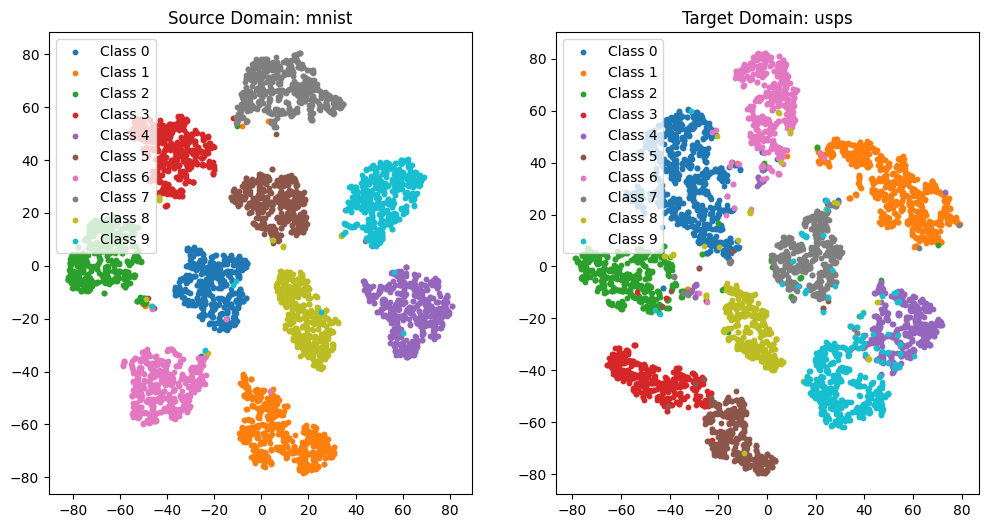

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============== Training on usps... =============
Visualizing feature distributions for usps to other domains...
============== Training on svhn... =============
Visualizing feature distributions for svhn to other domains...


In [33]:
# Visualization function
def visualize_feature_distributions_dan(model, source_loader, target_loader, device, source, target_D):
    model.eval()
    source_features, target_features = [], []
    source_labels, target_labels = [], []
    domain_labels_source, domain_labels_target = [], []  # To store domain information for color-coding
    domain_map = {"mnist": 0, "usps": 1, "svhn": 2}  # Mapping domain names to numbers

    # Collect features and labels for the source domain
    with torch.no_grad():
        for inputs, targets in source_loader:
            inputs = inputs.to(device)

            # Extract features and predictions
            features, _ = model(inputs)  # Extract features only
            source_features.append(features.cpu().numpy())
            source_labels.append(targets.numpy())
            domain_labels_source.extend([domain_map[source]] * len(targets))

    # Collect features and labels for the target domain
    with torch.no_grad():
        for inputs, targets in target_loader:
            inputs = inputs.to(device)

            # Extract features and predictions
            features, _ = model(inputs)  # Extract features only
            target_features.append(features.cpu().numpy())
            target_labels.append(targets.numpy())
            domain_labels_target.extend([domain_map[target_D]] * len(targets))

    # Concatenate features and labels
    source_features = np.concatenate(source_features, axis=0)
    source_labels = np.concatenate(source_labels, axis=0)
    target_features = np.concatenate(target_features, axis=0)
    target_labels = np.concatenate(target_labels, axis=0)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    reduced_source_features = tsne.fit_transform(source_features)
    reduced_target_features = tsne.fit_transform(target_features)

    # Plot source features by class
    plt.figure(figsize=(12, 6))

    # Create a scatter plot for each class in the source domain
    plt.subplot(1, 2, 1)
    for class_id in np.unique(source_labels):
        class_indices = np.where(source_labels == class_id)[0]
        plt.scatter(reduced_source_features[class_indices, 0],
                    reduced_source_features[class_indices, 1],
                    label=f"Class {class_id}",
                    s=10)
    plt.title(f"Source Domain: {source}")
    plt.legend(loc='upper left')

    # Create a scatter plot for each class in the target domain
    plt.subplot(1, 2, 2)
    for class_id in np.unique(target_labels):
        class_indices = np.where(target_labels == class_id)[0]
        plt.scatter(reduced_target_features[class_indices, 0],
                    reduced_target_features[class_indices, 1],
                    label=f"Class {class_id}",
                    s=10)
    plt.title(f"Target Domain: {target_D}")
    plt.legend(loc='upper left')

    plt.show()

# Main script
epochs = 5
lr = 0.001
num_classes = 10  # Number of classes for MNIST, USPS, and SVHN
domains = ["mnist", "usps", "svhn"]

for source in domains:
    # Initialize the model
    dan_model = DAN(num_classes).to(device)
    dan_model = dan_model.to(device)

    print(f"============== Training on {source}... =============")

    # accuracy = evaluate_model(model, source_loader, device)
    # print(f"Accuracy with {source}: {accuracy * 100:.2f}%")
    # accuracy_results[(source, source)] = accuracy
    # # Visualize feature distributions
    print(f"Visualizing feature distributions for {source} to other domains...")
    for target in domains:
        if source != target:
            if (source, target) in [("mnist", "usps")]:  # Only visualize specific pairs
                source_dataset, source_loader = load_digit_dataset(source)
                target_dataset, target_loader = load_digit_dataset(target)
                train_dan(dan_model, source_loader, target_loader, device, epochs, lr)
                visualize_feature_distributions_dan(dan_model, source_loader, target_loader, device, source, target)


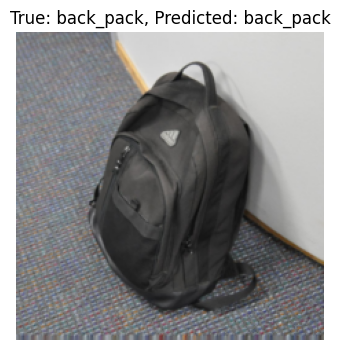

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def predict_and_visualize(model, data_loader, device, classes):
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Take the first image and label from the batch
            input_image, label = inputs[0], labels[0]

            # Move the image to the device
            input_image = input_image.to(device).unsqueeze(0)

            # Make a prediction
            _, outputs = model(input_image)
            _, pred = torch.max(outputs, 1)

            # Get the predicted and true class labels
            predicted_label = classes[pred.item()]
            true_label = classes[label.item()]

            # Display the input image
            plt.figure(figsize=(4, 4))

            # Un-normalize the image (if normalized during preprocessing)
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])

            # Move mean and std to the same device as the input image for computation
            mean = mean.to(input_image.device)
            std = std.to(input_image.device)

            # Perform unnormalization
            unnormalized_image = input_image[0].permute(1, 2, 0) * std + mean
            unnormalized_image = unnormalized_image.cpu().numpy()
            unnormalized_image = np.clip(unnormalized_image, 0, 1)  # Clip values to valid range

            # Plot the image
            plt.imshow(unnormalized_image)
            plt.title(f"True: {true_label}, Predicted: {predicted_label}")
            plt.axis("off")
            plt.show()

            break  # Only predict and display one image


classes = office_31_classes
predict_and_visualize(dan_model, data_loader=target_loader, device=device, classes=classes)


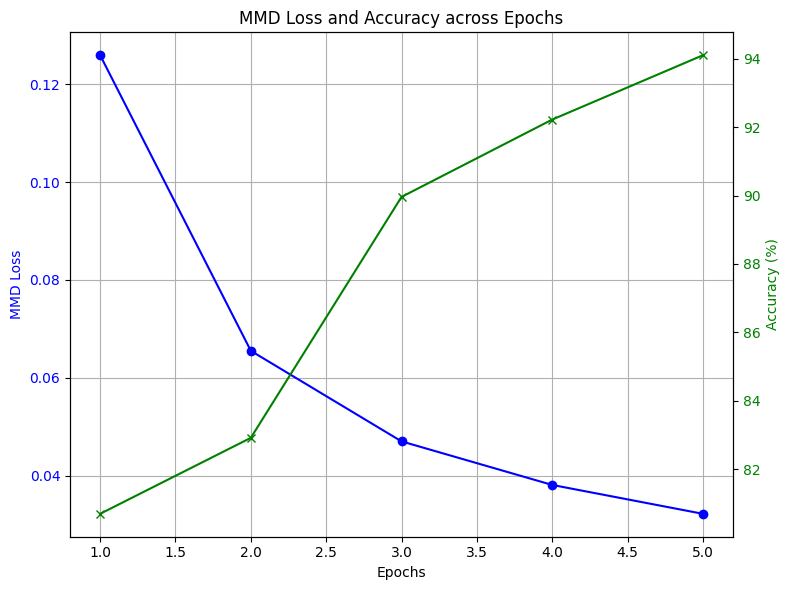

In [28]:
import matplotlib.pyplot as plt

# Data from training logs
epochs = [1, 2, 3, 4, 5]
mmd_loss = [0.1259, 0.0655, 0.0470, 0.0381, 0.0322]  # MMD Loss
accuracy = [80.70, 82.92, 89.96, 92.22, 94.1]  # Target Accuracy these values were taken by running the code in other notebook

# Create the figure and the first y-axis for MMD loss
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('MMD Loss', color='blue')
ax1.plot(epochs, mmd_loss, marker='o', color='blue', label='MMD Loss')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='green')
ax2.plot(epochs, accuracy, marker='x', color='green', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='green')

# Title and legend
plt.title('MMD Loss and Accuracy across Epochs')
fig.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


# DANN - Domain Adversarial Neural Networks (DANN)

In [5]:
# Define FeatureExtractor
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=256):
        super(FeatureExtractor, self).__init__()
        # Load a pre-trained ResNet-50 model and remove the fully connected layer
        resnet = resnet50(pretrained=True)
        # Remove the final fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)  # (N, 2048, 1, 1)
        # Use an Adaptive Average Pooling to reduce output to desired dimensions
        self.fc = nn.Linear(resnet.fc.in_features, hidden_dims)

    def forward(self, x):
        h = self.resnet(x)  # Extract features using ResNet-50
        h = h.view(h.size(0), -1)  # Flatten (N, 2048)
        h = self.fc(h)  # Fully connected layer to hidden dimensions
        return h

# Define Classifier
class Classifier(nn.Module):
    def __init__(self, input_size=256, num_classes=31):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size=256, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

def initialize_models(NUM_Classes, hidden_dims=256):
    F = FeatureExtractor().to(device)
    C = Classifier(input_size=256, num_classes=NUM_Classes).to(device)
    D = Discriminator().to(device)
    return F, C, D

# Get learning rate for training
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1 + np.exp(-10. * p)) - 1.

def sample_batch(loader, step, n_batches):
    # Initialize iterator only if needed
    if 'loader_iter' not in locals():  # Check if loader_iter is not already defined
        loader_iter = iter(loader)  # Create a new iterator

    return next(loader_iter)  # Use the built-in `next` function


In [6]:
# Train DAN
def train_dann(F, C, D, src_loader, tgt_loader, epochs, lr):
    F_opt = torch.optim.Adam(F.parameters(), lr=lr)
    C_opt = torch.optim.Adam(C.parameters(), lr=lr)
    D_opt = torch.optim.Adam(D.parameters(), lr=lr)

    bce = nn.BCELoss()
    xe = nn.CrossEntropyLoss()

    max_epoch = epochs
    step = 0
    n_critic = 1  # For training more steps about Discriminator
    n_batches = len(src_loader.dataset) // src_loader.batch_size

    for epoch in tqdm(range(1, max_epoch + 1), desc="Training", unit="epoch"):
        total_loss = 0.0
        for idx, (src_images, labels) in enumerate(src_loader):
            # Sample a batch from the target loader
            tgt_images, _ = sample_batch(tgt_loader, step, n_batches)

            # Move data to device
            src, labels, tgt = src_images.to(device), labels.to(device), tgt_images.to(device)

            # Concatenate source and target images for the shared feature extractor
            x = torch.cat([src, tgt], dim=0)
            h = F(x)
            # Discriminator output
            y = D(h)

            # Compute discriminator loss (Ld)
            domain_labels = torch.cat([torch.ones(src.size(0), 1), torch.zeros(tgt.size(0), 1)], dim=0).to(device)
            Ld = bce(y, domain_labels)
            D.zero_grad()
            Ld.backward(retain_graph=True)  # Use retain_graph=True to keep the graph alive
            D_opt.step()

            # Compute classifier loss (Lc) on source images
            c = C(h[:src.size(0)])
            y = D(h)
            Lc = xe(c, labels)
            Ld = bce(y, domain_labels)

            # Compute total loss (Lc + weighted Ld)
            lamda = 0.1 * get_lambda(epoch, max_epoch)
            Ltotal = Lc - lamda * Ld  # Use subtraction for adversarial domain alignment

            # Zero gradients and backward pass for the total loss
            F.zero_grad()
            C.zero_grad()
            D.zero_grad()

            # Ltotal.backward(retain_graph=True)  # Ensure graph is retained
            Ltotal.backward(retain_graph=True)  # Ensure graph is retained

            # Update weights
            C_opt.step()
            F_opt.step()

            # Accumulate loss for monitoring
            total_loss += Ltotal.item()

            step += 1

        print(f"Epoch [{epoch}/{max_epoch}], Loss: {total_loss / len(src_loader):.4f}")


# Evaluate DAN on a loader
def evaluate_dann(F, C, D, loader):
    F.eval()
    C.eval()
    corrects = torch.zeros(1).to(device)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            c = C(F(images))
            _, preds = torch.max(c, 1)
            corrects += (preds == labels).sum()

    acc = corrects.item() / len(loader.dataset)
    print(f'***** Eval Result: {acc:.4f}')
    F.train()
    C.train()

    return acc


In [ ]:
epochs = 5
lr = 0.001
num_classes = 31
# Define the domains
domains = ["amazon", "dslr", "webcam"]
accuracy_results_DANN = {}

# Train and evaluate DAN for each domain transfer task
for source in domains:
    for target in domains:
        if source != target:
            print(f"========== Training DANN from {source} to {target}... ==========")
            source_dataset, source_loader = load_office31(source)
            target_dataset, target_loader = load_office31(target)

            F, C, D = initialize_models(num_classes)
            F, C, D = F.to(device), C.to(device), D.to(device)
            train_dann(F, C, D, source_loader, target_loader, epochs, lr)

            accuracy = evaluate_dann(F, C, D, target_loader)
            print(f"Accuracy with DAN {source} to {target}: {accuracy * 100:.2f}%")
            accuracy_results_DANN[(source, target)] = accuracy

# Print the final results
for (source, target), acc in accuracy_results_DANN.items():
    print(f"Source: {source}, Target: {target}, Accuracy: {acc * 100:.2f}%")

========== Training DANN from amazon to dslr... ==========


Training:  20%|██        | 1/5 [03:02<12:11, 182.96s/epoch]

Epoch [1/5], Loss: 3.3221


Training:  40%|████      | 2/5 [06:07<09:11, 183.77s/epoch]

Epoch [2/5], Loss: 3.1535


Training:  60%|██████    | 3/5 [09:11<06:08, 184.16s/epoch]

Epoch [3/5], Loss: 3.1081


Training:  80%|████████  | 4/5 [12:15<03:04, 184.08s/epoch]

Epoch [4/5], Loss: 2.9577


Training: 100%|██████████| 5/5 [15:20<00:00, 184.06s/epoch]

Epoch [5/5], Loss: 2.7950


***** Eval Result: 0.0843
Accuracy with DAN amazon to dslr: 8.43%
========== Training DANN from amazon to webcam... ==========


Training:  20%|██        | 1/5 [02:29<09:57, 149.27s/epoch]

Epoch [1/5], Loss: 3.1662


Training:  40%|████      | 2/5 [04:59<07:28, 149.55s/epoch]

Epoch [2/5], Loss: 2.7917


Training:  60%|██████    | 3/5 [07:28<04:58, 149.34s/epoch]

Epoch [3/5], Loss: 2.5311


Training:  80%|████████  | 4/5 [09:57<02:29, 149.35s/epoch]

Epoch [4/5], Loss: 2.3695


Training: 100%|██████████| 5/5 [12:26<00:00, 149.33s/epoch]

Epoch [5/5], Loss: 2.1979


***** Eval Result: 0.0906
Accuracy with DAN amazon to webcam: 9.06%
========== Training DANN from dslr to amazon... ==========


Training:  20%|██        | 1/5 [00:26<01:44, 26.10s/epoch]

Epoch [1/5], Loss: 3.1902


Training:  40%|████      | 2/5 [00:52<01:18, 26.16s/epoch]

Epoch [2/5], Loss: 2.8770


Training:  60%|██████    | 3/5 [01:18<00:52, 26.11s/epoch]

Epoch [3/5], Loss: 2.5078


Training:  80%|████████  | 4/5 [01:44<00:26, 26.14s/epoch]

Epoch [4/5], Loss: 2.1663


Training: 100%|██████████| 5/5 [02:10<00:00, 26.06s/epoch]

Epoch [5/5], Loss: 2.1792


***** Eval Result: 0.0753
Accuracy with DAN dslr to amazon: 7.53%
========== Training DANN from dslr to webcam... ==========


Training:  20%|██        | 1/5 [00:28<01:52, 28.05s/epoch]

Epoch [1/5], Loss: 3.2323


Training:  40%|████      | 2/5 [00:55<01:23, 27.90s/epoch]

Epoch [2/5], Loss: 2.9485


Training:  60%|██████    | 3/5 [01:23<00:55, 27.89s/epoch]

Epoch [3/5], Loss: 2.4405


Training:  80%|████████  | 4/5 [01:51<00:27, 27.90s/epoch]

Epoch [4/5], Loss: 2.1556


Training: 100%|██████████| 5/5 [02:19<00:00, 27.87s/epoch]

Epoch [5/5], Loss: 1.9924


***** Eval Result: 0.1899
Accuracy with DAN dslr to webcam: 18.99%
========== Training DANN from webcam to amazon... ==========


Training:  20%|██        | 1/5 [00:39<02:39, 39.77s/epoch]

Epoch [1/5], Loss: 3.3495


Training:  40%|████      | 2/5 [01:19<01:59, 39.85s/epoch]

Epoch [2/5], Loss: 3.0491


Training:  60%|██████    | 3/5 [01:59<01:19, 39.84s/epoch]

Epoch [3/5], Loss: 2.7954


Training:  80%|████████  | 4/5 [02:39<00:39, 39.76s/epoch]

Epoch [4/5], Loss: 2.6216


Training: 100%|██████████| 5/5 [03:18<00:00, 39.79s/epoch]

Epoch [5/5], Loss: 2.4698


***** Eval Result: 0.0355
Accuracy with DAN webcam to amazon: 3.55%
========== Training DANN from webcam to dslr... ==========


Training:  20%|██        | 1/5 [00:52<03:30, 52.64s/epoch]

Epoch [1/5], Loss: 2.9934


Training:  40%|████      | 2/5 [01:45<02:37, 52.60s/epoch]

Epoch [2/5], Loss: 2.4870


Training:  60%|██████    | 3/5 [02:38<01:45, 52.86s/epoch]

Epoch [3/5], Loss: 2.0898


Training:  80%|████████  | 4/5 [03:31<00:52, 52.93s/epoch]

Epoch [4/5], Loss: 1.7787


Training: 100%|██████████| 5/5 [04:24<00:00, 52.82s/epoch]

Epoch [5/5], Loss: 1.4141


***** Eval Result: 0.2631
Accuracy with DAN webcam to dslr: 26.31%
Source: amazon, Target: dslr, Accuracy: 8.43%
Source: amazon, Target: webcam, Accuracy: 9.06%
Source: dslr, Target: amazon, Accuracy: 7.53%
Source: dslr, Target: webcam, Accuracy: 18.99%
Source: webcam, Target: amazon, Accuracy: 3.55%
Source: webcam, Target: dslr, Accuracy: 26.31%


In [ ]:
# Function to load data based on domain
def load_digit_dataset(domain):
    if domain == "mnist":
        return load_mnist('./data')
    elif domain == "usps":
        return load_usps('./data')
    elif domain == "svhn":
        return load_svhn('./data')

# Visualization function for DANN
def visualize_feature_distributions_dann(F, source_loader, target_loader, device, source, target):
    F.eval()  # Set the feature extractor to evaluation mode
    source_features, target_features = [], []
    source_labels, target_labels = [], []
    domain_map = {"mnist": 0, "usps": 1, "svhn": 2}  # Mapping domain names to numbers

    # Collect features and labels for the source domain
    with torch.no_grad():
        for inputs, targets in source_loader:
            inputs = inputs.to(device)
            # Extract features using the feature extractor (F)
            features = F(inputs)
            source_features.append(features.cpu().numpy())
            source_labels.append(targets.numpy())

    # Collect features and labels for the target domain
    with torch.no_grad():
        for inputs, targets in target_loader:
            inputs = inputs.to(device)
            # Extract features using the feature extractor (F)
            features = F(inputs)
            target_features.append(features.cpu().numpy())
            target_labels.append(targets.numpy())

    # Concatenate features and labels
    source_features = np.concatenate(source_features, axis=0)
    source_labels = np.concatenate(source_labels, axis=0)
    target_features = np.concatenate(target_features, axis=0)
    target_labels = np.concatenate(target_labels, axis=0)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    all_features = np.concatenate([source_features, target_features], axis=0)
    reduced_features = tsne.fit_transform(all_features)

    # Split the reduced features back into source and target
    reduced_source_features = reduced_features[:len(source_features)]
    reduced_target_features = reduced_features[len(source_features):]

    # Plot the features
    plt.figure(figsize=(12, 6))

    # Source domain
    plt.subplot(1, 2, 1)
    for class_id in np.unique(source_labels):
        indices = np.where(source_labels == class_id)[0]
        plt.scatter(reduced_source_features[indices, 0], reduced_source_features[indices, 1],
                    label=f"Class {class_id}", s=10)
    plt.title(f"Source Domain: {source}")
    plt.legend(loc='upper left')

    # Target domain
    plt.subplot(1, 2, 2)
    for class_id in np.unique(target_labels):
        indices = np.where(target_labels == class_id)[0]
        plt.scatter(reduced_target_features[indices, 0], reduced_target_features[indices, 1],
                    label=f"Class {class_id}", s=10)
    plt.title(f"Target Domain: {target}")
    plt.legend(loc='upper left')

    plt.show()

# Main script
epochs = 5
lr = 0.001
num_classes = 10  # Number of classes for MNIST, USPS, and SVHN
domains = ["mnist", "usps", "svhn"]

for source in domains:
    for target in domains:
        if source != target:
            if (source, target) in [("mnist", "usps")]:
              print(f"========== Training DANN from {source} to {target}... ==========")

              source_dataset, source_loader = load_digit_dataset(source)
              target_dataset, target_loader = load_digit_dataset(target)

              F, C, D = initialize_models(num_classes)
              F, C, D = F.to(device), C.to(device), D.to(device)

              train_dann(F, C, D, source_loader, target_loader, epochs, lr)

              # # Evaluate the DANN model on the target domain
              # accuracy = evaluate_dann(F, C, D, target_loader)
              # print(f"Accuracy with DANN {source} to {target}: {accuracy * 100:.2f}%")
              # accuracy_results_DANN[(source, target)] = accuracy

              # Visualize feature distributions for source and target domains
              print(f"========== Visualizing Feature Distributions for {source} to {target} ==========")
              visualize_feature_distributions_dann(F, source_loader, target_loader, device, source, target)

========== Training DANN from mnist to usps... ==========


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training:  20%|██        | 1/5 [04:07<16:29, 247.30s/epoch]

Epoch [1/5], Loss: 0.4636


Training:  40%|████      | 2/5 [08:13<12:20, 246.83s/epoch]

Epoch [2/5], Loss: 0.1285
